# DenseNet Implementation with Tensorflow-Keras

* Based on the paper **"Denseley Connected Convolutional Neural Networks"**

* Implemented By Mohammad Hassan Heydari

In [1]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     Dense, AvgPool2D, GlobalAveragePooling2D, MaxPool2D,
                                     ReLU, concatenate)

from keras.models import Model
import keras

In [2]:
# this function returns a block of batch-->relu-->conv for simplification
def batch_relu_conv(x, num_filters, conv_name, kernel_shape=(3, 3), strides=1):

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_shape, strides=strides, padding='same', name = conv_name)(x)
    return x

# this function returns a dense-conv block with k=num_convs conv layers
def dense_block(x, num_blocks, block_name):
    merge = []
    merge.append(x)
    for i in range(num_blocks):
        y = batch_relu_conv(x, num_filters= 64 , conv_name = f'{block_name}-dense_conv{i}')
        y = batch_relu_conv(y, num_filters= 64, conv_name =f'{block_name}-dense_relu{i}')
        merge.append(y)
        x = concatenate(merge)
    return x

# this function returns a transition block based on batch-relu-conv and avgpool
# which we use after every dense block
def transition_layer(x, name):

    from random import randint
    x = batch_relu_conv(x, num_filters= 128, conv_name = name)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x



* **Plotting The Dense block with k=4 convs**

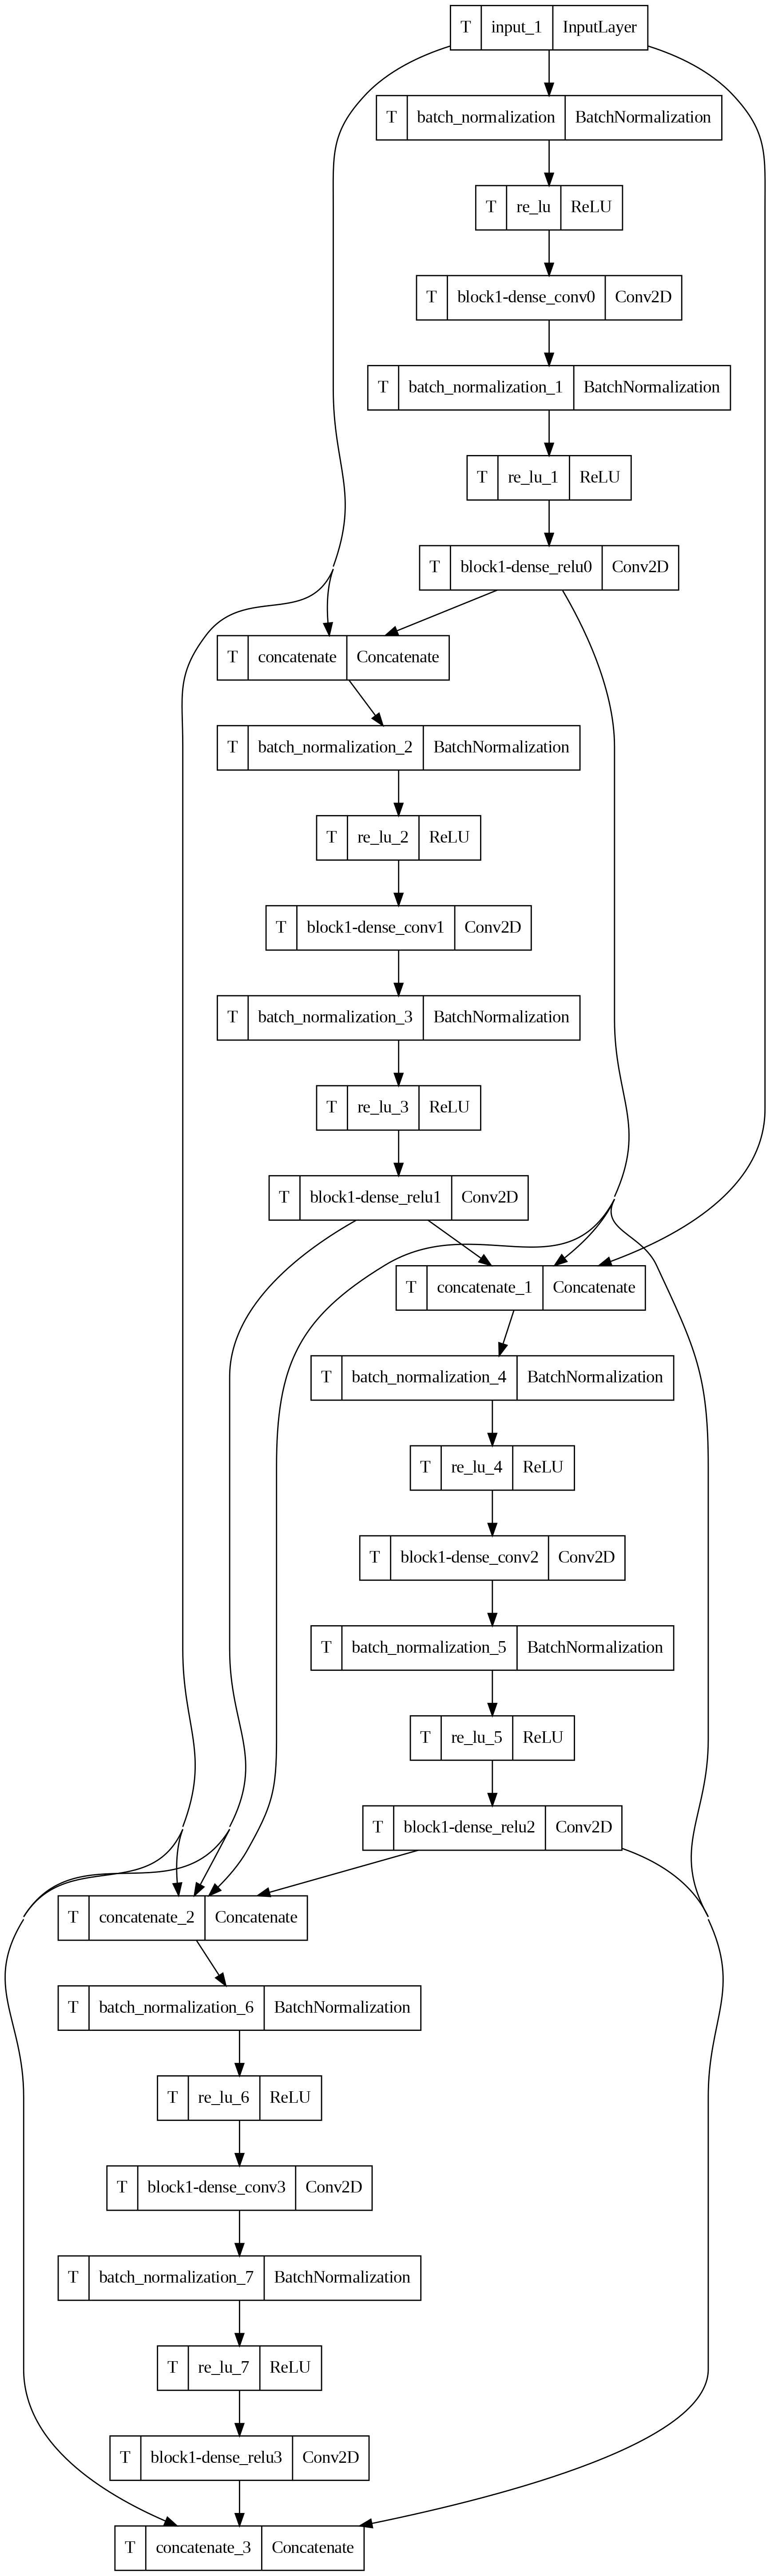

In [3]:
# checking the dense block implementation
x_input = Input(shape = (128, 128, 3))

x = dense_block(x_input, 4, block_name = 'block1')


model_test = Model(x_input, x)
keras.utils.plot_model(
    model_test,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=False,
    show_trainable=True,

)


* **creating model to classify CIFAR10**

In [4]:
from keras.datasets import cifar10


def load_cifar10_data():

    num_classes = 10
    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()



    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train[:10000], Y_train[:10000], X_valid[:2000], Y_valid[:2000]

X_train, y_train, X_test, y_test = load_cifar10_data()
y_train.resize(y_train.shape[0])
y_test.resize(y_test.shape[0])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000,)
(2000, 32, 32, 3)
(2000,)


In [5]:
# Assuming X_train and X_test are your numpy arrays of images
# And each image in X_train and X_test is of shape (height, width, channels)

from tensorflow.image import resize

def resize_images(images):
    return resize(images, [128, 128])

X_train = resize_images(X_train)
X_test = resize_images(X_test)

print(X_train.shape, X_test.shape, sep = '\n')

(10000, 128, 128, 3)
(2000, 128, 128, 3)


# Defining our actual model to train on CIFAR10 dataset

In [6]:
# defining model with 3 dense blocks and k=4
x_input = Input(shape = (128, 128, 3))
x = transition_layer(x_input, name='transition_1')
x = dense_block(x, 4, block_name = 'block_1')
x = transition_layer(x, name= 'transition_2')
x = dense_block(x, 4, block_name = 'block_2')
x = transition_layer(x, name= 'transition_3')
x = dense_block(x, 4, block_name = 'block_3')
x = transition_layer(x, name= 'transition_4')
x = keras.layers.Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(x_input, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 batch_normalization_8 (Bat  (None, 128, 128, 3)          12        ['input_2[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 128, 128, 3)          0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                            

In [7]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [10]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = 32)

Epoch 1/5
313/313 [==============================] - 89s 283ms/step - loss: 1.5248 - accuracy: 0.4422 - val_loss: 1.8297 - val_accuracy: 0.3620
Epoch 2/5
313/313 [==============================] - 88s 282ms/step - loss: 1.4118 - accuracy: 0.4937 - val_loss: 1.5979 - val_accuracy: 0.4910
Epoch 3/5
313/313 [==============================] - 88s 282ms/step - loss: 1.3048 - accuracy: 0.5221 - val_loss: 1.6052 - val_accuracy: 0.4990
Epoch 4/5
313/313 [==============================] - 89s 283ms/step - loss: 1.2128 - accuracy: 0.5631 - val_loss: 1.2095 - val_accuracy: 0.5615
Epoch 5/5
313/313 [==============================] - 89s 283ms/step - loss: 1.0796 - accuracy: 0.6118 - val_loss: 1.1970 - val_accuracy: 0.5835
